# Outline

**Task**

Need to classify the image into the appropriate consonant and vowel class. Data consists of images of letters in hindi with a random colored background (constaining, dogs, cats, scenery, mountains etc.)

Here is the [link](https://docs.google.com/spreadsheets/d/10qPM7qFuJIGgyGFduBe-HGghvH66FQ8grPGgwYPoFvs/edit#gid=1824507407) to Vowel-Consonant Mapping Google Sheet

There are two sets of one ho vectors for vowels and consonants in labels tensors. First OHE for vowels. Second OHE for consonant. Both #classes = 10

# Setup

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt;plt.style.use('ggplot')
import numpy as np
import copy
from IPython.display import clear_output
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms

#For converting the dataset to torchvision dataset format
class VowelConsonantDataset(Dataset):
    def __init__(self, file_path,train=True,transform=None):
        self.transform = transform
        self.file_path=file_path
        self.train=train
        self.file_names=[file for _,_,files in os.walk(self.file_path) for file in files]
        self.len = len(self.file_names)
        if self.train:
            self.classes_mapping=self.get_classes()
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        file_name=self.file_names[index]
        image_data=self.pil_loader(self.file_path+"/"+file_name)
        if self.transform:
            image_data = self.transform(image_data)
        if self.train:
            file_name_splitted=file_name.split("_")
            Y1 = self.classes_mapping[file_name_splitted[0]]
            Y2 = self.classes_mapping[file_name_splitted[1]]
            z1,z2=torch.zeros(10),torch.zeros(10)
            z1[Y1-10],z2[Y2]=1,1
            label=torch.stack([z1,z2])

            return image_data, label

        else:
            return image_data, file_name
          
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

      
    def get_classes(self):
        classes=[]
        for name in self.file_names:
            name_splitted=name.split("_")
            classes.extend([name_splitted[0],name_splitted[1]])
        classes=list(set(classes))
        classes_mapping={}
        for i,cl in enumerate(sorted(classes)):
            classes_mapping[cl]=i
        return classes_mapping
    

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets

import torchvision.transforms as transforms
import torchvision.models as models_tv
import numpy as np
import pandas as pd

train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");print(device)

cuda:0


# DataLoading

In [55]:
transform = transforms.Compose([transforms.ColorJitter(),transforms.Resize(256),transforms.CenterCrop(227),transforms.ToTensor()])
full_data = VowelConsonantDataset("../input/padhai-hindi-vow-cons-classification/train/train",train=True,transform=transform)
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size
batch_size = 64
train_data, validation_data = random_split(full_data, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_data = VowelConsonantDataset("../input/padhai-hindi-vow-cons-classification/test/test",train=False,transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=False)

print("Train (Full) Dataset Size: ", full_data.__len__())
print("Train (Train) Dataset Size: ", full_data.__len__()*0.9)
print("Train (Validation) Dataset Size: ", full_data.__len__()*0.1)
print("Test Dataset Size: ", test_data.__len__())

Train (Full) Dataset Size:  10000
Train (Train) Dataset Size:  9000.0
Train (Validation) Dataset Size:  1000.0
Test Dataset Size:  10000


In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape,labels.shape)
# print(labels)
#There are two sets of one ho vectors for vowels and consonants in labels tensors. 
#First OHE for vowels. Second OHE for consonant. Both #classes = 10

torch.Size([64, 3, 227, 227]) torch.Size([64, 2, 10])


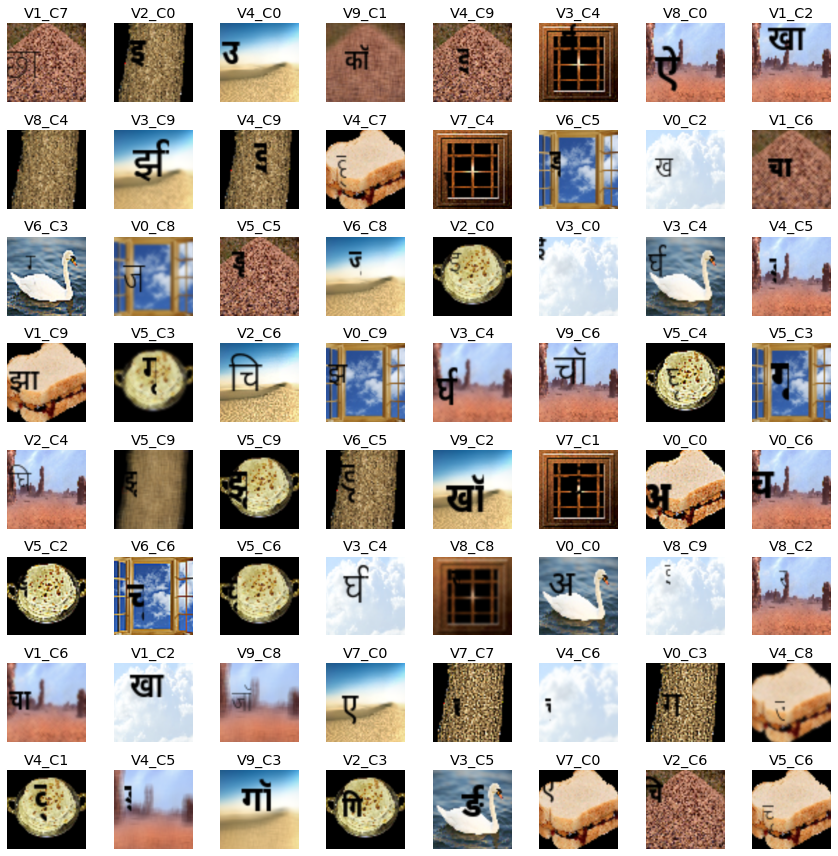

In [63]:
#Data Visualization
ncols = 8;nrows = 8;plt_scale = 1.5
trans_tensor_PIL = transforms.ToPILImage(mode='RGB')
fig = plt.figure(figsize=(plt_scale*ncols, plt_scale*nrows))
count = 0
for i in range(nrows*ncols):
    count += 1
    ax1 = fig.add_subplot(nrows, ncols, count)
    ax1.imshow(trans_tensor_PIL(images[i]))
    v = torch.argmax(labels[i],dim=1)
    ax1.set_title('V'+str(v[0].item()) + '_' + 'C' + str(v[1].item()))
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

plt.tight_layout()
plt.show()

# Model & Training

In [34]:
class resnetCustom(nn.Module):
    def __init__(self,num_classes_vow = 10, num_classes_con = 10, fc_size = 1024):
        super(resnetCustom,self).__init__()
        self.fc_size = fc_size
        self.num_classes_vow = num_classes_vow
        self.num_classes_con = num_classes_con
        self.resnet = models_tv.resnet18(pretrained = True)
#         for params in self.resnet.parameters():
#             params.requires_grad = False
        resnet_fc_in = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(resnet_fc_in,fc_size),
            nn.ReLU(),
            nn.Dropout(0.2))
        nn.init.kaiming_uniform_(self.resnet.fc[0].weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(self.resnet.fc[0].bias)
        self.classifier_vow = nn.Linear(fc_size,num_classes_vow)
        self.classifier_con = nn.Linear(fc_size,num_classes_con)
        nn.init.xavier_uniform_(self.classifier_vow.weight)
        nn.init.xavier_uniform_(self.classifier_con.weight)
        nn.init.zeros_(self.classifier_vow.bias)
        nn.init.zeros_(self.classifier_con.bias)
        
    def forward(self,x):
        x = self.resnet(x)
        vowels = self.classifier_vow(x)
        consonants = self.classifier_con(x)
        return vowels, consonants
        
def print_net(net):
    print("Printing shapes of layers that are in training mode")
    for param in net.parameters():
        if(param.requires_grad == True):
            print(param.shape)

In [35]:
net = resnetCustom().to(device)
print_net(net)

Printing shapes of layers that are in training mode
torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([25

In [36]:
best_model  = copy.deepcopy(net.state_dict())
loss_itr = []
min_loss = 1000

In [95]:
def evaluation(net,data_loader):
    net.eval()
    correct,total = 0,0
    for data in data_loader:
        images, labels = data
        images = images.to(device)
        
        with torch.no_grad():
            out1,out2 = net(images)
        target_vows = torch.argmax(labels[:,0,:],dim=1).to(device)
        target_cons = torch.argmax(labels[:,1,:],dim=1).to(device)
        pred_vows = torch.argmax(out1.data,dim=1)
        pred_cons = torch.argmax(out2.data,dim=1)
        
        correct += torch.logical_and((pred_vows == target_vows), (pred_cons == target_cons)).sum().item()
        total += labels.size(0)
        #print(images.shape,pred_vows.shape,target_vows.shape)
    return 100*correct/total  
    
def train(min_loss, max_epochs = 1, lr = 0.005, momentum = 0.9, nesterov=True, display_freq=50, display_loss = True, device = device):
    opt = optim.SGD(net.parameters(), momentum = momentum, lr = lr,nesterov=nesterov)
#     opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4, amsgrad=True)
    criterion = nn.CrossEntropyLoss()
    n_iters = np.ceil(train_size/batch_size)
    
    best_model  = copy.deepcopy(net.state_dict())
    for epoch in range(max_epochs):
        
        #Mini-Batch Pass
        for i, data in enumerate(train_loader, 0):
            
            net.train();opt.zero_grad()
            #Input & Label pre-processing
            images, labels = data
            images = images.to(device)
            target_vows = torch.argmax(labels[:,0,:],dim=1).to(device)
            target_cons = torch.argmax(labels[:,1,:],dim=1).to(device)
            pred_vows, pred_cons = net(images)
            loss_vows = criterion(pred_vows,target_vows)
            loss_cons = criterion(pred_cons,target_cons)
            loss = torch.add(loss_vows,loss_cons)
            
            loss_itr.append(loss.item())
            if(min_loss > loss.item()):
                min_loss = loss.item()
                best_model  = copy.deepcopy(net.state_dict())
                print('Min Loss %0.3f' % min_loss)
            
            if not (i%display_freq):
                clear_output(wait=True)
                print('Iteration: %d/%d, Train Loss: %0.3f' % (i, n_iters, loss.item()))
                if(display_loss):
                    plt.plot(loss_itr);plt.xlabel('Iterations');plt.ylabel('Train Loss');plt.show()
                    plt.plot();print('\n\n')
                
            loss.backward();opt.step()
            
    return best_model, min_loss

def save_model(best_model):
    checkpoint = {'state_dict': best_model}
    torch.save(checkpoint, 'checkpoint.pth')
    
def load_model(filepath):
    checkpoint = torch.load(filepath)
    net.load_state_dict(checkpoint['state_dict'])

Iteration: 140/141, Train Loss: 0.262


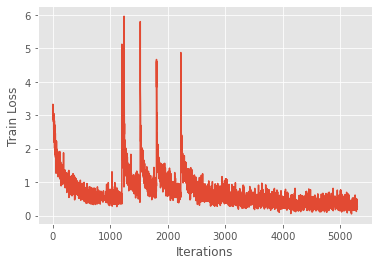

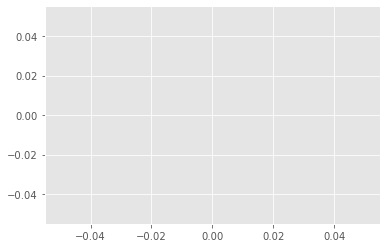

In [77]:
load_model('checkpoint.pth')
best_model, min_loss = train(min_loss, max_epochs = 3, lr = 0.0001/2, momentum = 0.7,nesterov=True, display_freq=20, display_loss = True, device = device)
save_model(best_model)

In [79]:
min_loss
load_model('checkpoint.pth')

In [99]:
print("Printing Training Set & Validation Set Accuracies")
print("Train Acc: %0.3f    Validation Acc: %0.3f" % (evaluation(net,train_loader),evaluation(net,validation_loader)))

Printing Training Set & Validation Set Accuracies
Train Acc: 90.856    Validation Acc: 81.400


# Submission

In [108]:
load_model('checkpoint.pth')
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

def evaluation_f1(net,data_loader):
    net.eval()
    correct,total = 0,0
    ypred, yground = [],[]
    for data in data_loader:
        images, labels = data
        images = images.to(device)
        
        with torch.no_grad():
            out1,out2 = net(images)
        target_vows = torch.argmax(labels[:,0,:],dim=1).to(device)
        target_cons = torch.argmax(labels[:,1,:],dim=1).to(device)
        pred_vows = torch.argmax(out1.data,dim=1)
        pred_cons = torch.argmax(out2.data,dim=1)
        ypred.append(pred_vows.tolist());ypred.append(pred_cons.tolist());
        yground.append(target_vows.tolist());yground.append(target_cons.tolist())
        correct += torch.logical_and((pred_vows == target_vows), (pred_cons == target_cons)).sum().item()
        total += labels.size(0)
        #print(images.shape,pred_vows.shape,target_vows.shape)
#     f1 = f1_score(yground, ypred, average='weighted')
    f1 = f1_score(mlb.fit_transform(yground), mlb.fit_transform(ypred), average='weighted')
    pr = precision_score(mlb.fit_transform(yground), mlb.fit_transform(ypred), average='weighted')
    re = recall_score(mlb.fit_transform(yground), mlb.fit_transform(ypred), average='weighted')
    print(f1, pr,re)
    return 100*correct/total, f1
evaluation_f1(net,validation_loader)

0.9968652037617555 0.9968652037617555 0.9968652037617555


(81.4, 0.9968652037617555)

In [98]:
load_model('checkpoint.pth')
net.eval()
plist=[]
fn_list=[]
for inputs_test, fn in test_loader:
    inputs_test=inputs_test.to(device)
    with torch.no_grad():
        out1,out2=net(inputs_test)
    pred_vows = torch.argmax(out1.data,dim=1).tolist()
    pred_cons = torch.argmax(out2.data,dim=1).tolist()
    for x,y,z in zip(pred_vows,pred_cons,fn):
        p="V"+str(x)+"_"+"C"+str(y)
        plist.append(p)
        fn_list.append(z)
        
submission = pd.DataFrame({"ImageId":fn_list, "Class":plist})
submission.to_csv('submission.csv', index=False)